<a href="https://colab.research.google.com/github/johanhoffman/Coimbra_2023/blob/main/demo_elastodynamics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Implementation and adaption of code from: https://fenicsproject.org/olddocs/dolfin/latest/python/demos/elastodynamics/demo_elastodynamics.py.html


**Setup environment**

In [ ]:
# Load neccessary modules.
from google.colab import files

import numpy as np
import time

# Install FEniCS (this may take a long time)
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import dolfin
    
from dolfin import *; from mshr import *

import dolfin.common.plotting as fenicsplot

from matplotlib import pyplot as plt

# Form compiler options
parameters["form_compiler"]["cpp_optimize"] = True
parameters["form_compiler"]["optimize"] = True


**Create domain and mesh**

In [ ]:
# Define mesh
mesh = BoxMesh(Point(0., 0., 0.), Point(1., 0.1, 0.04), 60, 10, 5)

# Sub domain for clamp at left end
def left(x, on_boundary):
    return near(x[0], 0.) and on_boundary

# Sub domain for rotation at right end
def right(x, on_boundary):
    return near(x[0], 1.) and on_boundary

**Material model**

In [ ]:
# Elastic parameters
E  = 1000.0
nu = 0.3
mu    = Constant(E / (2.0*(1.0 + nu)))
lmbda = Constant(E*nu / ((1.0 + nu)*(1.0 - 2.0*nu)))

# Mass density
rho = Constant(1.0)

# Rayleigh damping coefficients
eta_m = Constant(0.)
eta_k = Constant(0.)

**Time discretization**

In [ ]:
# Generalized-alpha method parameters
alpha_m = Constant(0.2)
alpha_f = Constant(0.4)
gamma   = Constant(0.5+alpha_f-alpha_m)
beta    = Constant((gamma+0.5)**2/4.)

# Time-stepping parameters
T       = 4.0
Nsteps  = 50
dt = Constant(T/Nsteps)

**Loading**

In [ ]:
p0 = 1.
cutoff_Tc = T/5
# Define the loading as an expression depending on t
p = Expression(("0", "t <= tc ? p0*t/tc : 0", "0"), t=0, tc=cutoff_Tc, p0=p0, degree=0)

**Finite element approximation spaces**

In [ ]:
# Define function space for displacement, velocity and acceleration
V = VectorFunctionSpace(mesh, "CG", 1)
# Define function space for stresses
Vsig = TensorFunctionSpace(mesh, "DG", 0)

**Test and trial functions**

In [ ]:
# Test and trial functions
du = TrialFunction(V)
u_ = TestFunction(V)
# Current (unknown) displacement
u = Function(V, name="Displacement")
# Fields from previous time step (displacement, velocity, acceleration)
u_old = Function(V)
v_old = Function(V)
a_old = Function(V)

**Boundary conditions**

In [ ]:
# Create mesh function over the cell facets
boundary_subdomains = MeshFunction("size_t", mesh, mesh.topology().dim() - 1)
boundary_subdomains.set_all(0)
force_boundary = AutoSubDomain(right)
force_boundary.mark(boundary_subdomains, 3)

# Define measure for boundary condition integral
dss = ds(subdomain_data=boundary_subdomains)

# Set up boundary condition at left end
zero = Constant((0.0, 0.0, 0.0))
bc = DirichletBC(V, zero, left)

**FEM variational form**

In [ ]:
# Stress tensor
def sigma(r):
    return 2.0*mu*sym(grad(r)) + lmbda*tr(sym(grad(r)))*Identity(len(r))

# Mass form
def m(u, u_):
    return rho*inner(u, u_)*dx

# Elastic stiffness form
def k(u, u_):
    return inner(sigma(u), sym(grad(u_)))*dx

# Rayleigh damping form
def c(u, u_):
    return eta_m*m(u, u_) + eta_k*k(u, u_)

# Work of external forces
def Wext(u_):
    return dot(u_, p)*dss(3)

**Time stepping**

In [ ]:
# Update formula for acceleration
# a = 1/(2*beta)*((u - u0 - v0*dt)/(0.5*dt*dt) - (1-2*beta)*a0)
def update_a(u, u_old, v_old, a_old, ufl=True):
    if ufl:
        dt_ = dt
        beta_ = beta
    else:
        dt_ = float(dt)
        beta_ = float(beta)
    return (u-u_old-dt_*v_old)/beta_/dt_**2 - (1-2*beta_)/2/beta_*a_old

# Update formula for velocity
# v = dt * ((1-gamma)*a0 + gamma*a) + v0
def update_v(a, u_old, v_old, a_old, ufl=True):
    if ufl:
        dt_ = dt
        gamma_ = gamma
    else:
        dt_ = float(dt)
        gamma_ = float(gamma)
    return v_old + dt_*((1-gamma_)*a_old + gamma_*a)

def update_fields(u, u_old, v_old, a_old):
    """Update fields at the end of each time step."""

    # Get vectors (references)
    u_vec, u0_vec  = u.vector(), u_old.vector()
    v0_vec, a0_vec = v_old.vector(), a_old.vector()

    # use update functions using vector arguments
    a_vec = update_a(u_vec, u0_vec, v0_vec, a0_vec, ufl=False)
    v_vec = update_v(a_vec, u0_vec, v0_vec, a0_vec, ufl=False)

    # Update (u_old <- u)
    v_old.vector()[:], a_old.vector()[:] = v_vec, a_vec
    u_old.vector()[:] = u.vector()

In [ ]:
def avg(x_old, x_new, alpha):
    return alpha*x_old + (1-alpha)*x_new

# Residual
a_new = update_a(du, u_old, v_old, a_old, ufl=True)
v_new = update_v(a_new, u_old, v_old, a_old, ufl=True)
res = m(avg(a_old, a_new, alpha_m), u_) + c(avg(v_old, v_new, alpha_f), u_) \
       + k(avg(u_old, du, alpha_f), u_) - Wext(u_)
a_form = lhs(res)
L_form = rhs(res)

In [ ]:
# Define solver for reusing factorization
K, res = assemble_system(a_form, L_form, bc)
solver = LUSolver(K, "mumps")
solver.parameters["symmetric"] = True

In [ ]:
# Time-stepping
time = np.linspace(0, T, Nsteps+1)
u_tip = np.zeros((Nsteps+1,))
energies = np.zeros((Nsteps+1, 4))
E_damp = 0
E_ext = 0
sig = Function(Vsig, name="sigma")
xdmf_file = XDMFFile("elastodynamics-results.xdmf")
xdmf_file.parameters["flush_output"] = True
xdmf_file.parameters["functions_share_mesh"] = True
xdmf_file.parameters["rewrite_function_mesh"] = False

In [ ]:
def local_project(v, V, u=None):
    """Element-wise projection using LocalSolver"""
    dv = TrialFunction(V)
    v_ = TestFunction(V)
    a_proj = inner(dv, v_)*dx
    b_proj = inner(v, v_)*dx
    solver = LocalSolver(a_proj, b_proj)
    solver.factorize()
    if u is None:
        u = Function(V)
        solver.solve_local_rhs(u)
        return u
    else:
        solver.solve_local_rhs(u)
        return

for (i, dt) in enumerate(np.diff(time)):

    t = time[i+1]
    print("Time: ", t)

    # Forces are evaluated at t_{n+1-alpha_f}=t_{n+1}-alpha_f*dt
    p.t = t-float(alpha_f*dt)

    # Solve for new displacement
    res = assemble(L_form)
    bc.apply(res)
    solver.solve(K, u.vector(), res)


    # Update old fields with new quantities
    update_fields(u, u_old, v_old, a_old)

    # Save solution to XDMF format
    xdmf_file.write(u, t)

    # Compute stresses and save to file
    local_project(sigma(u), Vsig, sig)
    xdmf_file.write(sig, t)

    p.t = t
    # Record tip displacement and compute energies
    # Note: Only works in serial
    if MPI.comm_world.size == 1:
        u_tip[i+1] = u(1., 0.05, 0.)[1]
    E_elas = assemble(0.5*k(u_old, u_old))
    E_kin = assemble(0.5*m(v_old, v_old))
    E_damp += dt*assemble(c(v_old, v_old))
    # E_ext += assemble(Wext(u-u_old))
    E_tot = E_elas+E_kin+E_damp #-E_ext
    energies[i+1, :] = np.array([E_elas, E_kin, E_damp, E_tot])

Time:  0.08
Time:  0.16
Time:  0.24
Time:  0.32
Time:  0.4
Time:  0.48
Time:  0.56
Time:  0.64
Time:  0.72
Time:  0.8
Time:  0.88
Time:  0.96
Time:  1.04
Time:  1.12
Time:  1.2
Time:  1.28
Time:  1.36
Time:  1.44
Time:  1.52
Time:  1.6
Time:  1.68
Time:  1.76
Time:  1.84
Time:  1.92
Time:  2.0
Time:  2.08
Time:  2.16
Time:  2.24
Time:  2.32
Time:  2.4
Time:  2.48
Time:  2.56
Time:  2.64
Time:  2.72
Time:  2.8000000000000003
Time:  2.88
Time:  2.96
Time:  3.04
Time:  3.12
Time:  3.2
Time:  3.2800000000000002
Time:  3.36
Time:  3.44
Time:  3.52
Time:  3.6
Time:  3.68
Time:  3.7600000000000002
Time:  3.84
Time:  3.92
Time:  4.0


**Plot results**

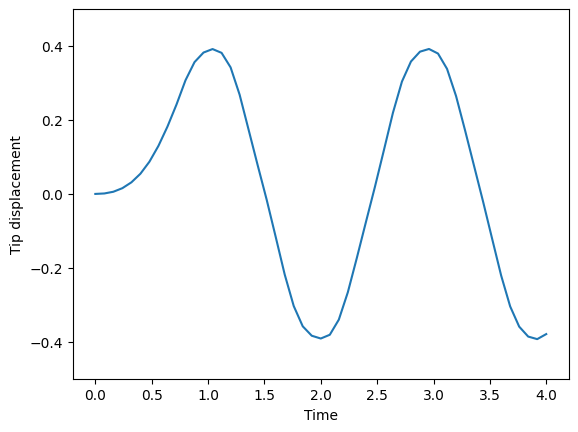

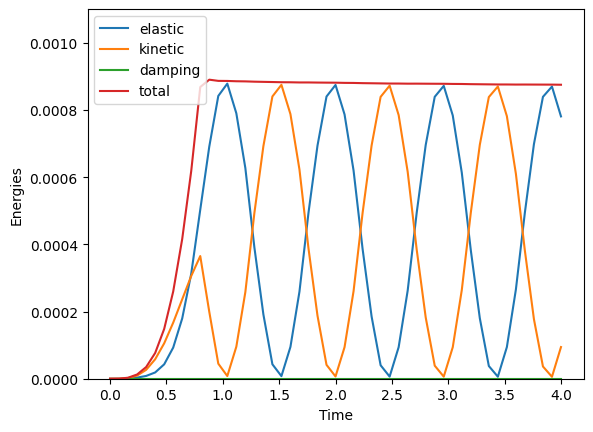

In [ ]:
if MPI.comm_world.size == 1:
    # Plot tip displacement evolution
    plt.figure()
    plt.plot(time, u_tip)
    plt.xlabel("Time")
    plt.ylabel("Tip displacement")
    plt.ylim(-0.5, 0.5)
    plt.show()

if (MPI.comm_world.rank == 0):
    # Plot energies evolution
    plt.figure()
    plt.plot(time, energies)
    plt.legend(("elastic", "kinetic", "damping", "total"))
    plt.xlabel("Time")
    plt.ylabel("Energies")
    plt.ylim(0, 0.0011)
    plt.show()